In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

## Create a folder for the this HW and change to that dir
%cd drive/MyDrive/cse519_educational_ranking/Datasets/Final_Report_Datasets

Mounted at /content/drive
/content/drive/MyDrive/cse519_educational_ranking/Datasets/Final_Report_Datasets


In [ ]:
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn
!pip install -q ranky

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ranky as rk
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error

In [ ]:
def merge_multiple_csv_files(file_paths, index_names, join_method):

    merged_df = pd.read_csv(file_paths[0])
    for i in range(1, len(file_paths)):
        merged_df = pd.merge(merged_df, pd.read_csv(file_paths[i]),
                             left_on=index_names[0], right_on=index_names[i], how=join_method)
    return merged_df

In [ ]:
file_paths = ['openalex-concepts-data.csv', 'IPEDS_2021 - CSV_11152023-658.csv', '2021_RnDExpenditures_final_HERD.csv',
              'ncses_Doctorate_Recipients.csv', 'US-News-Rankings-Universities 2012.csv', 'arwu.csv',
              'compsci_arwu.csv', 'biosci_arwu.csv', 'qs.csv'
              ]
index_names = ['UNITID', 'unitid', 'UnitID', 'UnitID', 'IPEDS ID', 'UNITID',
                'UNITID', 'UNITID', 'UNITID'
               ]

In [ ]:
merged_df = merge_multiple_csv_files(file_paths= file_paths, index_names = index_names, join_method = 'left')

In [ ]:
print(merged_df.columns)

Index(['Unnamed: 0_x', 'display_name', 'id', 'works_count', 'cited_by_count',
       'h_index', 'i10_index', 'city', 'region', '2yr_mean_citedness',
       ...
       'Total Score', 'Q1_y', 'CNCI_y', 'IC_y', 'TOP_y', 'AWARD_y', 'Bio_Rank',
       'Unnamed: 0', 'Institution', 'QS_Rank'],
      dtype='object', length=133)


In [ ]:
columns_to_exclude = ['Unnamed: 0_x', 'unitid', 'Institution Name', 'UnitID_x', 'Name', 'UnitID_y', 'University Name', 'IPEDS ID', 'year',
                   'DRVF2021.Research expenses as a percent of total core expenses (GASB)',
                   'DRVF2021.Research expenses as a percent of total core expenses (FASB)',
                   'DRVF2021.Research expenses as a percent of total core expenses (for-profit institutions)',
                   'DRVF2021.Salaries and wages for research as a percent of total expenses for research (GASB)',
                   'DRVF2021.Salaries and wages for research as a percent of total expenses for research (FASB)',
                   'DRVF2021.Salaries and wages for research as a percent of total expenses for research (for-profit institutions)' , 'Institution']

In [ ]:
dropped_merged_df = merged_df.drop(columns=columns_to_exclude)

In [ ]:
dropped_merged_df.replace(',','', regex=True, inplace=True)
dropped_merged_df.replace('-','0', regex=True, inplace=True)
columns_to_convert = ['R&D Expenditures by Detailed Funding Source',
       'R&D Expenditures by Broad Field and Fed and Nonfed Sources',
       'R&D Expenditures Passed Through to Subrecipients',
       'R&D Expenditures Received as a Subrecipient from Other Sources',
       '2021_Doctorate_Recipients']
for col in columns_to_convert:
  dropped_merged_df[col].fillna(0)
  dropped_merged_df[col] = dropped_merged_df[col].astype(str).astype(float)


In [ ]:
dropped_merged_df["Total R&D Expenditure"] = dropped_merged_df[['R&D Expenditures by Detailed Funding Source',
      # 'R&D Expenditures by Broad Field and Fed and Nonfed Sources',
      'R&D Expenditures Passed Through to Subrecipients',
      'R&D Expenditures Received as a Subrecipient from Other Sources']].sum(axis=1)


In [ ]:
dropped_merged_df = dropped_merged_df.drop(dropped_merged_df[dropped_merged_df['Total R&D Expenditure'] == 0].index)

In [ ]:
# dropped_merged_df.to_csv('merged_data.csv')

In [ ]:
dropped_merged_df = dropped_merged_df.drop(dropped_merged_df[dropped_merged_df['UNITID'] == 122436].index)
dropped_merged_df = dropped_merged_df.drop(dropped_merged_df[dropped_merged_df['UNITID'] == 228343].index)
dropped_merged_df = dropped_merged_df.drop(dropped_merged_df[dropped_merged_df['UNITID'] == 122612].index)
# print(dropped_merged_df[dropped_merged_df['display_name'] == 'University of California San Diego'])

#Borda

In [ ]:
# Plot scatterplot
from scipy.stats import spearmanr

def plot_scatterplot(df, proxy_rank_col):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=df.index, y='our_ranking', data=df, color='#CCCCCC', label='Our Rankings')
    sns.scatterplot(x=df.index, y=proxy_rank_col, data=df, color='#C0299F', label=proxy_rank_col)

    # Adding labels and title
    plt.xlabel('University ID')
    plt.ylabel('Rankings')
    plt.title(f'Comparison of our rankings vs {proxy_rank_col}')

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()

# Evaluate our rankings

def eval_ranking(df, our_col, proxy_col):
    # Compute Spearman correlation
    correlation, p_value = spearmanr(df[our_col], df[proxy_col], nan_policy='omit')
    mae = mean_absolute_error(df[our_col], df[proxy_col])
    max_err = max_error(df[our_col], df[proxy_col])

    print(f"Mean Absolute Error: {mae}")
    print(f"Max Error: {max_err}")
    print(f"Spearman correlation coefficient: {correlation}")
    print(f"P-value: {p_value}")



# Rank a dataframe

def rank_dataframe_borda(df, rank_cols, proxy_rank_col):
    t = df[rank_cols]

    # t = t.set_index('UNITID')

    ranks = rk.borda(t) # returns pandas.core.series.Series
    ranks.name = 'borda_rank'

    # merged_df = pd.merge(df, ranks, left_on='UNITID', right_index=True, how='inner')
    merged_df = pd.merge(df, ranks, left_index=True, right_index=True, how='inner')

    z = merged_df.sort_values(by='borda_rank', ascending=True)

    z = z.dropna(subset=[proxy_rank_col])
    z.reset_index(drop=True, inplace=True)
    z['our_ranking'] = z.index + 1

    print(z[['our_ranking', 'display_name', 'borda_rank']].head(20))

    return z



# Metrics

In [ ]:
metrics_df = dropped_merged_df.copy()

In [ ]:
# metrics_df = metrics_df.dropna(subset=['Rankings_2022'])
metrics_df = metrics_df.dropna(subset=['ARWU Rank'])

In [ ]:
metrics_df['impact_index'] = metrics_df['h_index'] / np.power(metrics_df['works_count'], 0.4)
metrics_df['work_output_over_investment'] = np.power(metrics_df['works_count'], 2)/ np.power(metrics_df['Total R&D Expenditure'], 1)
metrics_df['work_quality'] = metrics_df['cited_by_count'] / metrics_df['works_count']
# metrics_df['alumni_quality'] = metrics_df['Award']/metrics_df['Alumni']
# metrics_df['graduate_over_enrollment'] = metrics_df['2021_Doctorate_Recipients']/metrics_df['EFIA2021_RV.Estimated full-time equivalent (FTE) graduate enrollment, 2020-21']

In [ ]:
# metrics_df = metrics_df.sort_values(by='impact_index', ascending=False)

# metrics_df['impact_index_rankings'] = range(1, len(metrics_df) + 1)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(metrics_df['impact_index_rankings'], metrics_df['Rankings_2022'])

# # Add labels and title
# plt.xlabel('Impact Index Rankings')
# plt.ylabel('Rankings_2022')
# plt.title('Rankings_2022 vs Impact Index Rankings')

# # Optional formatting
# plt.grid(True)
# plt.show()


    our_ranking                            display_name  borda_rank
0             1                      Harvard University    2.000000
1             2                     Stanford University    4.666667
2             3   Massachusetts Institute of Technology    5.000000
3             4       University of California Berkeley    5.333333
4             5                    Princeton University   10.000000
5             6                   University of Chicago   10.666667
6             7                         Yale University   14.333333
7             8                     Columbia University   15.000000
8             9      University of California San Diego   16.000000
9            10    University of California Los Angeles   16.666667
10           11  University of California Santa Barbara   17.000000
11           12              University of Pennsylvania   17.333333
12           13                University of Washington   18.000000
13           14      California Institute of Tec

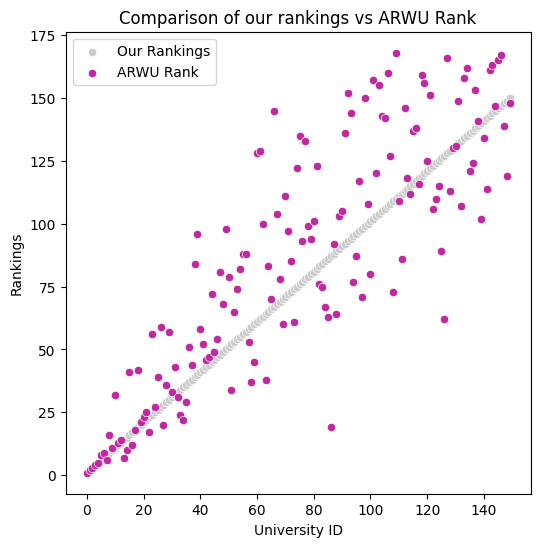

In [ ]:
rank_cols = [
    'impact_index',
    # 'Total R&D Expenditure',
    '2021_Doctorate_Recipients',
    'work_output_over_investment',
    'work_quality',
    # 'works_count'
]


df = metrics_df.copy()

ranked_df = rank_dataframe_borda(df, rank_cols, 'ARWU Rank')
eval_ranking(ranked_df, 'our_ranking', 'ARWU Rank')
plot_scatterplot(ranked_df, 'ARWU Rank')

In [ ]:
top_20_df = ranked_df[['UNITID', 'display_name', 'our_ranking']].head(21)

In [ ]:
top_20_df.to_csv('top_20_rankings.csv')

# Plots


In [ ]:
other_rankings_df = metrics_df[["UNITID", "ARWU Rank", 'QS_Rank']]

In [ ]:
plot_df = pd.merge(top_20_df, other_rankings_df, on="UNITID", how="left")

In [ ]:
plot_df = plot_df.dropna()

In [ ]:
print(plot_df)

    UNITID                            display_name  our_ranking  ARWU Rank  \
0   166027                      Harvard University            1        1.0   
1   243744                     Stanford University            2        2.0   
2   166683   Massachusetts Institute of Technology            3        3.0   
3   110635       University of California Berkeley            4        4.0   
4   186131                    Princeton University            5        5.0   
5   144050                   University of Chicago            6        8.0   
6   130794                         Yale University            7        9.0   
7   190150                     Columbia University            8        6.0   
8   110680      University of California San Diego            9       16.0   
9   110662    University of California Los Angeles           10       11.0   
10  110705  University of California Santa Barbara           11       32.0   
11  215062              University of Pennsylvania           12 

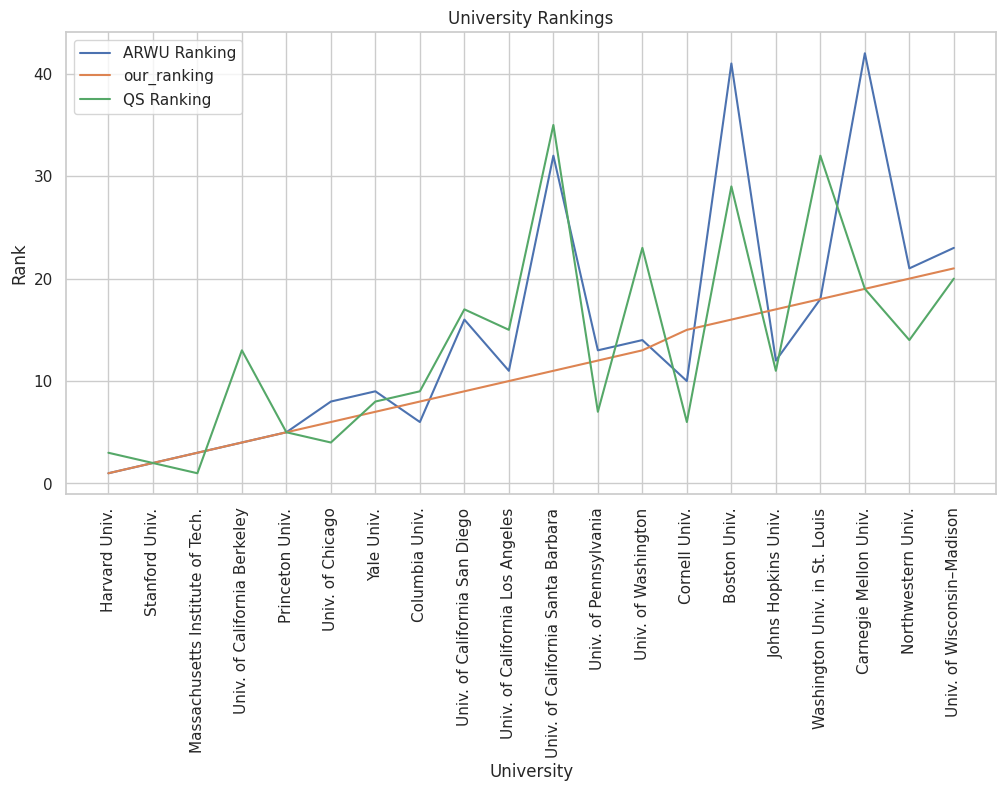

In [ ]:


def shorten_univ_name(s):
    s = s.replace('University', 'Univ.')
    s = s.replace('Technology', 'Tech.')
    # s = s.replace('The', '')
    return s

plot_df['short_display_name'] = plot_df['display_name'].apply(shorten_univ_name)


sns.set(style="whitegrid")

# Create a multi-line chart
plt.figure(figsize=(12, 6))

sns.lineplot(x='short_display_name', y='ARWU Rank', data=plot_df, label='ARWU Ranking')
sns.lineplot(x='short_display_name', y='our_ranking', data=plot_df, label='our_ranking')
sns.lineplot(x='short_display_name', y='QS_Rank', data=plot_df, label='QS Ranking')


# Set labels and title
# plt.xlabel('University')
plt.ylabel('Rank')
plt.title('University Rankings')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display the legend
plt.legend()

# Show the plot
plt.show()

**Find anomalies**

In [ ]:
our_ranking_df = ranked_df[["UNITID", "display_name", "our_ranking"]]
arwu_df = metrics_df[["UNITID", "ARWU Rank"]]
print(arwu_df.head())
print(our_ranking_df.head())

   UNITID  ARWU Rank
0  223232      115.0
1  153603      117.0
2  182281      147.0
4  186380       47.0
8  182290      125.0
   UNITID                            display_name  our_ranking
0  166027                      Harvard University            1
1  122612  University of California San Francisco            2
2  243744                     Stanford University            3
3  166683   Massachusetts Institute of Technology            4
4  110635       University of California Berkeley            5


In [ ]:

df = pd.merge(our_ranking_df, arwu_df, on="UNITID")

# Calculate the absolute difference between 'our_ranking' and 'ARWU Rank'
df["absolute_difference"] = abs(df["our_ranking"] - df["ARWU Rank"])


# Filter rows where the absolute difference is more than 100
result_df = df[df["absolute_difference"] > 80][["UNITID", "display_name", "our_ranking", "ARWU Rank"]]

# # Print or use the result_df as needed
print(result_df)

     UNITID                      display_name  our_ranking  ARWU Rank
18   183044       University of New Hampshire           19      126.0
105  170976  University of Michigan–Ann Arbor          104       19.0
144  232186           George Mason University          143       62.0


    our_ranking                            display_name  borda_rank
0             1                      Harvard University         2.5
1             2                     Stanford University         5.0
2             3       University of California Berkeley         8.0
3             4   Massachusetts Institute of Technology         8.0
4             5  University of California San Francisco        14.0
5             6              University of Pennsylvania        14.5
6             7                         Yale University        15.5
7             8                     Columbia University        16.0
8             9                University of Washington        16.0
9            10    University of California Los Angeles        17.0
10           11      University of California San Diego        17.5
11           12      University of California San Diego        17.5
12           13                   University of Chicago        18.0
13           14                      Cornell Uni

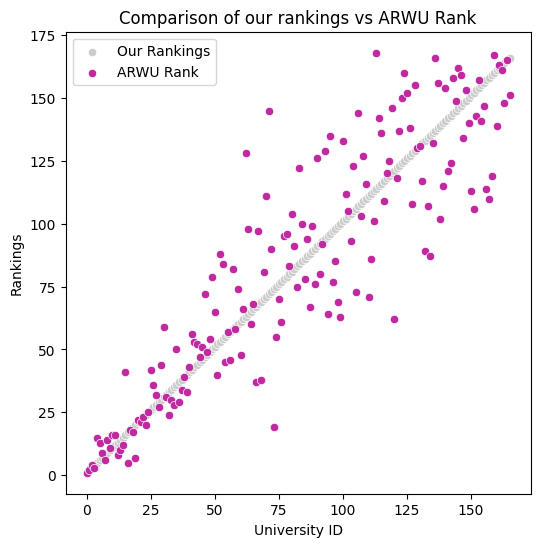

In [ ]:
rank_cols = [
    # 'UNITID',
    'impact_index',
    'Total R&D Expenditure',
    '2021_Doctorate_Recipients',
    'work_output_over_investment',
    'work_quality'
]

# rank_cols = [
#     'impact_index',
#     'works_count'
# ]

df = metrics_df.copy()

ranked_df_1 = rank_dataframe_borda(df, rank_cols, 'ARWU Rank')
eval_ranking(ranked_df_1, 'our_ranking', 'ARWU Rank')
plot_scatterplot(ranked_df_1, 'ARWU Rank')

In [ ]:
# Combine DataFrames
ranked_merged_df = pd.merge(ranked_df, ranked_df_1, on='UNITID')

# Extract data for plot
x_data = ranked_merged_df['our_ranking_x']
y_data = ranked_merged_df['our_ranking_y']
hover_text = ranked_merged_df['UNITID']


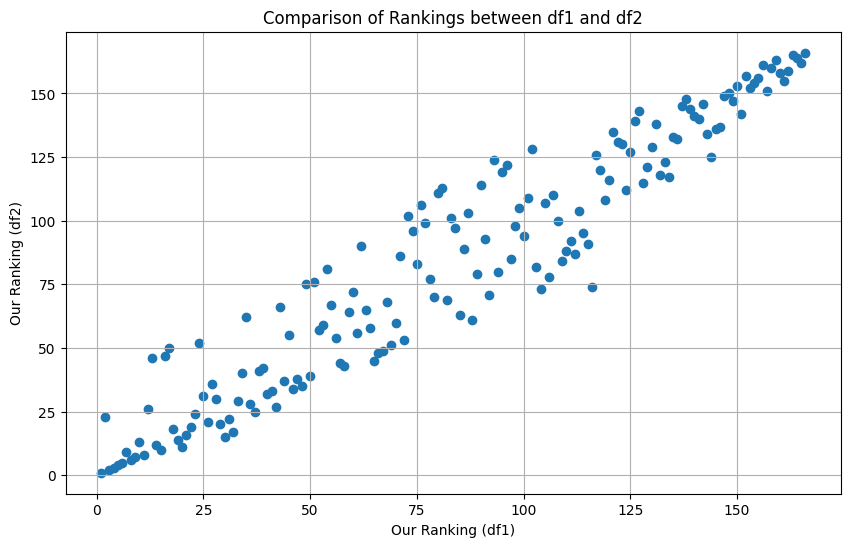

In [ ]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)


# Use the list for annotation
# plt.annotate(hover_text_list, (x_data, y_data), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and title
plt.xlabel('Our Ranking (df1)')
plt.ylabel('Our Ranking (df2)')
plt.title('Comparison of Rankings between df1 and df2')

# Show plot
plt.grid(True)
plt.show()

#CS Rankings

In [ ]:
cs_metrics_df = metrics_df.copy()
cs_metrics_df = cs_metrics_df.dropna(subset=['CompSci_Rank'])
cs_metrics_df = cs_metrics_df.dropna(subset=['concept-Computer science'])

In [ ]:
cs_metrics_df['CS_impact_index'] = (cs_metrics_df['h_index']*metrics_df['concept-Computer science']) / np.power(cs_metrics_df['works_count'], 0.4)
cs_metrics_df['CS_work'] = metrics_df['works_count']*metrics_df['concept-Computer science']


    our_ranking                             display_name  borda_rank
0             1    Massachusetts Institute of Technology        5.25
1             2                      Stanford University        5.25
2             3        University of California Berkeley        5.25
3             4                     Princeton University       13.25
4             5                 University of Washington       15.25
5             6                      Columbia University       17.75
6             7  University of Illinois Urbana0Champaign       17.75
7             8       University of California San Diego       18.75
8             9                       Harvard University       19.25
9            10     University of California Los Angeles       20.00
10           11                    University of Chicago       20.00
11           12               Carnegie Mellon University       21.25
12           13       California Institute of Technology       21.75
13           14   University of Ca

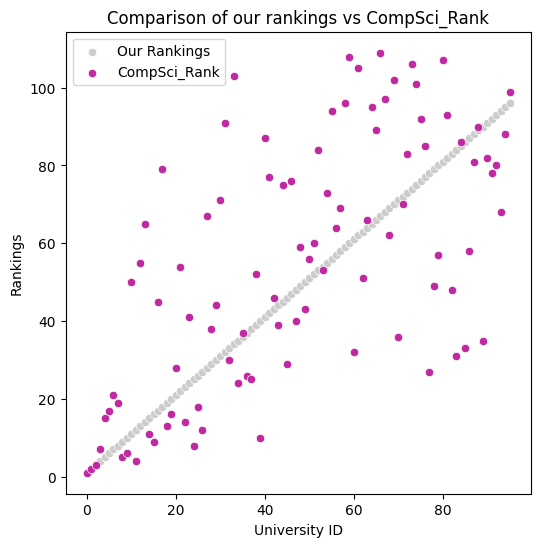

In [ ]:


rank_cols = [
    # 'impact_index',
    'CS_impact_index',
    # 'Total R&D Expenditure',
    '2021_Doctorate_Recipients',
    'work_output_over_investment',
    'work_quality',
    'CS_work',
]


df = cs_metrics_df.copy()

ranked_df_1 = rank_dataframe_borda(df, rank_cols, 'CompSci_Rank')
eval_ranking(ranked_df_1, 'our_ranking', 'CompSci_Rank')
plot_scatterplot(ranked_df_1, 'CompSci_Rank')

# Bio Rankigs

In [ ]:
bio_metrics_df = metrics_df.copy()
bio_metrics_df = bio_metrics_df.dropna(subset=['Bio_Rank'])
bio_metrics_df = bio_metrics_df.dropna(subset=['concept-Biology'])

In [ ]:
bio_metrics_df['Bio_impact_index'] = (bio_metrics_df['h_index']*bio_metrics_df['concept-Biology']) / np.power(bio_metrics_df['works_count'], 0.4)
bio_metrics_df['Bio_work'] = bio_metrics_df['works_count']*bio_metrics_df['concept-Biology']


    our_ranking                                 display_name  borda_rank
0             1                           Harvard University        1.25
1             2                          Stanford University        5.00
2             3                              Yale University       11.75
3             4           University of California San Diego       12.25
4             5                   University of Pennsylvania       12.50
5             6                     Johns Hopkins University       13.00
6             7         University of California Los Angeles       13.50
7             8                           Cornell University       13.50
8             9        Massachusetts Institute of Technology       15.50
9            10            University of California Berkeley       15.75
10           11                          Columbia University       16.50
11           12                     University of Washington       16.50
12           13                        University o

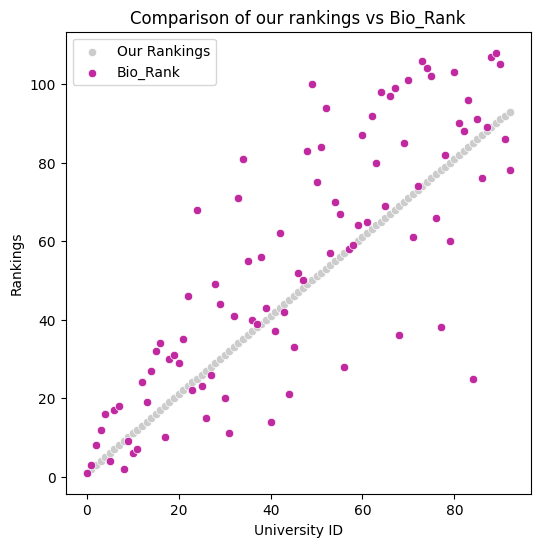

In [ ]:
rank_cols = [
    # 'impact_index',
    'Bio_impact_index',
    # # 'Total R&D Expenditure',
    '2021_Doctorate_Recipients',
    'work_output_over_investment',
    'work_quality',
    'Bio_work',
]


df = bio_metrics_df.copy()

ranked_df = rank_dataframe_borda(df, rank_cols, 'Bio_Rank')
eval_ranking(ranked_df, 'our_ranking', 'Bio_Rank')
plot_scatterplot(ranked_df, 'Bio_Rank')